# Programming Assignment 4
## Arnav Thaker


---

### Problem 1

Original image


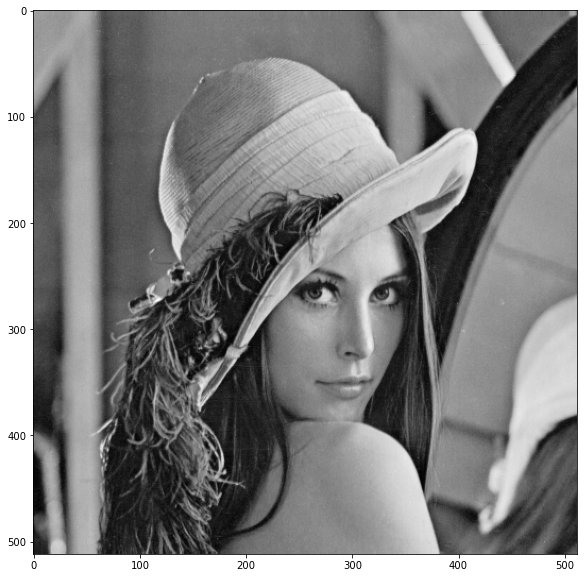

Apply the first convolution


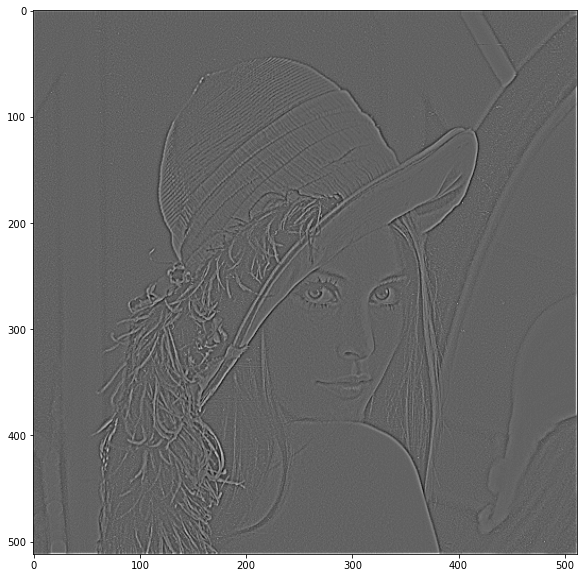

Apply the first convolution and ReLU


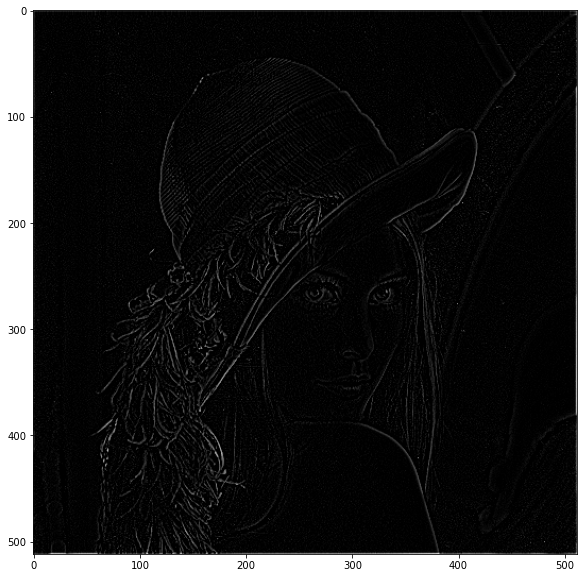

Apply the first convolution, ReLU and the second convolution


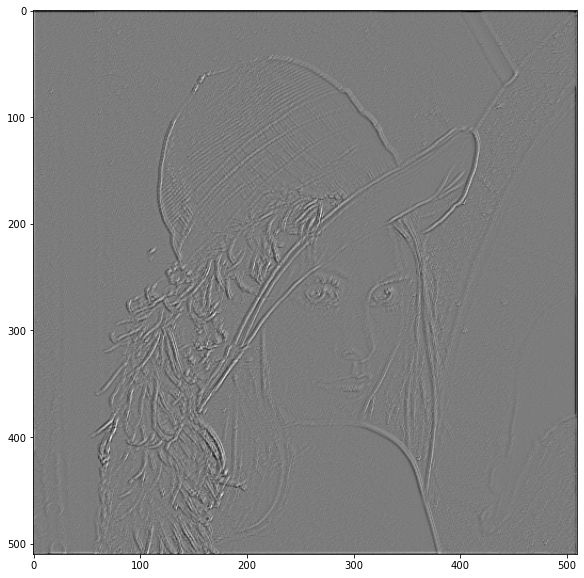

In [1]:
# You can finish the following code to solve Problem 1.
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

#Step I: Deal with the data
def read_image():    
    im = Image.open('./lena.png')
    im_array = np.array(im)
    # transfer im_array to 4th order torch.tensor 
    im_array=torch.from_numpy(im_array)
    im_array=im_array.reshape(1,1,im_array.size(0),im_array.size(1))
    im_array=im_array.type(torch.FloatTensor)
    return im_array

#Step II: Define a function to plot the image: give 4th order torch.tensor 

def plot_images(images):
    plt.rcParams["figure.figsize"]=10,10 # change the figure size for plotting
    images_for_plot = images[0,0,:,:] 
    plt.imshow(images_for_plot.detach().numpy(), cmap='gray') 
    plt.show()
    

#Step III: Define the operators
    
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()

        # Define the first convolutional layer
        kernel_1 = torch.tensor([[0, 0, -1, 0, 0], 
                                 [0, -1, -2, -1, 0], 
                                 [-1, -2, 16, -2, -1],
                                 [0, -1, -2, -1, 0],
                                 [0, 0, -1, 0, 0] ], dtype=torch.float32)
        # reshape your 2nd order tensor to 4th order tensor. Think about why?
        kernel_1 = kernel_1.reshape(1,1,kernel_1.size(0),kernel_1.size(1)) 
        self.conv1 = nn.Conv2d(1, 1, kernel_1.size(2), padding=2)
        # assign kernel_1 to conv1 layer.
        self.conv1.weight = torch.nn.Parameter(kernel_1)
        
        
        # Define the second convolutional layer
        kernel_2 = torch.tensor([ [1/9, 1/9, 1/9], 
                                [1/9, 1/9, 1/9], 
                                [1/9, 1/9, 1/9] ], dtype=torch.float32)
        kernel_2 = kernel_2.reshape(1, 1, kernel_2.size(0), kernel_2.size(1))
        self.conv2 = nn.Conv2d(1, 1, kernel_1.size(2), padding=1)
            
    def forward(self, x):
        x_conv1 = self.conv1(x)
        x_relu = F.relu(x_conv1)
        x_conv2 = self.conv2(x_relu)
        return x_conv1,x_relu,x_conv2
    
#Step IV: Show results:
x=read_image()
my_model=model()
x_conv1,x_relu,x_conv2 = my_model(x)

print('Original image')
plot_images(x)
print('Apply the first convolution')
plot_images(x_conv1)
print('Apply the first convolution and ReLU')
plot_images(x_relu)
print('Apply the first convolution, ReLU and the second convolution')
plot_images(x_conv2)

---

### Problem 2

In [2]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

# Define a LeNet-5
# No need to resize CIFAR10 images as they're already 32x32
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 in channels for RGB
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x)) # layer 1, convolution
        out = F.avg_pool2d(out, 2) # layer 2, pool
        out = F.relu(self.conv2(out)) # layer 3, convolution
        out = F.avg_pool2d(out, 2) # layer 4, pool
        out = out.view(out.size(0), -1)  # reshape to a 2 tensor
        out = F.relu(self.fc1(out))  # layer 5, linear map
        out = F.relu(self.fc2(out)) # layer 6, another linear map
        out = self.fc3(out) # layer 7, output layer
        return out


def adjust_learning_rate(optimizer, epoch, init_lr):
    lr = init_lr * 0.1** (epoch // 10)
    for param_groups in optimizer.param_groups:
        param_groups['lr'] = lr
    return lr

minBatch = 128
num_epochs = 30
lr = 0.1

# Step 1: Define a model
my_model =model()
if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, weight_decay = 0.00001)


# Step 3: load dataset
# load cifar data
CIFAR10_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                                                     std=(0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=CIFAR10_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=minBatch, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=CIFAR10_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)


#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    current_lr = adjust_learning_rate(optimizer, epoch, lr)
    for i, (images, labels) in enumerate(trainLoader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(images) 
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
        
    # Training accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainLoader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()  
        outputs = my_model(images)
        p_max, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()
    training_accuracy = 100 * float(correct)/total 

    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testLoader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outputs = my_model(images)
        p_max, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()
    test_accuracy = 100 * float(correct)/total
        
    print('Epoch: {}, Training accuracy: {}%, Test accuracy: {}%' .format(epoch+1, training_accuracy,test_accuracy)) 

Use GPU? False
Files already downloaded and verified
Epoch: 1, Training accuracy: 33.25%, Test accuracy: 34.12%
Epoch: 2, Training accuracy: 46.204%, Test accuracy: 45.87%
Epoch: 3, Training accuracy: 52.678%, Test accuracy: 51.29%
Epoch: 4, Training accuracy: 56.192%, Test accuracy: 53.93%
Epoch: 5, Training accuracy: 57.764%, Test accuracy: 54.47%
Epoch: 6, Training accuracy: 57.188%, Test accuracy: 53.12%
Epoch: 7, Training accuracy: 59.742%, Test accuracy: 54.93%
Epoch: 8, Training accuracy: 64.786%, Test accuracy: 58.33%
Epoch: 9, Training accuracy: 63.758%, Test accuracy: 57.72%
Epoch: 10, Training accuracy: 65.526%, Test accuracy: 57.76%
Epoch: 11, Training accuracy: 71.162%, Test accuracy: 61.53%
Epoch: 12, Training accuracy: 71.766%, Test accuracy: 61.59%
Epoch: 13, Training accuracy: 72.454%, Test accuracy: 61.84%
Epoch: 14, Training accuracy: 72.642%, Test accuracy: 61.72%
Epoch: 15, Training accuracy: 73.052%, Test accuracy: 61.72%
Epoch: 16, Training accuracy: 73.548%, Tes